#1) Introdução

Este estudo tem como objetivo aplicar conceitos de clusterização em ações que compõem o Índice Bovespa (Ibovespa), utilizando como variáveis (features) dados de análise técnica, como as bandas de Bollinger. Para isso, foi gerado um arquivo CSV a partir do site da B3, contendo a composição atual do Ibovespa. Em seguida, utilizamos a biblioteca yfinance para coletar e compilar o dataset necessário para a análise.

A clusterização permitirá identificar padrões e comportamentos semelhantes entre as ações do índice, proporcionando uma visão mais aprofundada sobre suas dinâmicas de mercado. É importante ressaltar que as informações apresentadas neste estudo são apenas para fins acadêmicos e de pesquisa, não constituindo recomendações de compra ou venda.

#2) Preparação do ambiente

##2.1) Instalando bibliotecas

In [ ]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.5 MB/s eta 0:00:00


##2.2) Importando Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from yellowbrick.cluster import kelbow_visualizer

import ipywidgets as widgets
from ipywidgets import interact
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

##2.3) Gerando Dataset com yfinance

In [ ]:
#Composição do Ibovespa
ibov_composition = pd.read_csv('/content/IBOVDia_29-10-24.csv', encoding='latin1', header=1, sep=';')

In [ ]:
tickers = list(ibov_composition.index[:-2])

In [ ]:
#Adicionando sufixo .SA
tickers_sa = [ticker + '.SA' for ticker in tickers]

In [ ]:
data = []

for ticker in tickers_sa:
    aux = yf.download(ticker, start='2023-01-01', progress= False)[['Adj Close', 'Volume']]
    aux.reset_index(inplace=True)  # Reseta o índice para transformar a data em uma coluna
    aux['Ticker'] = ticker  # Adiciona uma coluna com o ticker correspondente
    aux.columns = aux.columns.droplevel(1)  # Remove o primeiro nível do MultiIndex

    data.append(aux)

ERROR:yfinance:Could not get exchangeTimezoneName for ticker 'EQTL3.SA' reason: 'chart'
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['EQTL3.SA']: possibly delisted; no timezone found


In [ ]:
# Concatenando todos os DataFrames em um único DataFrame
abt_data = pd.concat(data, ignore_index=True)

# Garantindo que 'final_data' é um DataFrame
abt_data = pd.DataFrame(abt_data)

In [ ]:
abt_data.head()

Price,Date,Adj Close,Volume,Ticker
0,2023-10-18 00:00:00+00:00,20.722937,11414800.0,ALOS3.SA
1,2023-10-19 00:00:00+00:00,20.694664,6982300.0,ALOS3.SA
2,2023-10-20 00:00:00+00:00,20.751209,4901300.0,ALOS3.SA
3,2023-10-23 00:00:00+00:00,21.542807,6902500.0,ALOS3.SA
4,2023-10-24 00:00:00+00:00,21.985725,5883300.0,ALOS3.SA


#3) Preparação dos Dados

In [ ]:
#Conferindo tipagem dos dados e presença de nulos
abt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38483 entries, 0 to 38482
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       38483 non-null  datetime64[ns, UTC]
 1   Adj Close  38483 non-null  float64            
 2   Volume     38483 non-null  float64            
 3   Ticker     38483 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(1)
memory usage: 1.2+ MB


In [ ]:
# Checando se todos os tickers possuem o mesmo período de análise
# Obtendo a data mínima do DataFrame principal
data_minima_geral = abt_data['Date'].min()

# Filtrando tickers cuja data mínima não coincide com a data mínima geral
tickers_inconsistentes = abt_data.groupby('Ticker')['Date'].min().reset_index()
tickers_inconsistentes = tickers_inconsistentes.query('Date != @data_minima_geral')

tickers_inconsistentes

,Ticker,Date
1,ALOS3.SA,2023-10-18 00:00:00+00:00
15,BRAV3.SA,2024-09-02 00:00:00+00:00


In [ ]:
#Remover tickers inconsistentes do dataframe
tickers_inconsistentes_list = tickers_inconsistentes['Ticker'].tolist()
abt_data = abt_data[~abt_data['Ticker'].isin(tickers_inconsistentes_list)]

In [ ]:
def calcular_bandas_bollinger(df, window=20, num_std=2):
    # Aplica o cálculo de bandas de Bollinger para cada grupo de ticker
    df = df.groupby('Ticker', group_keys=False).apply(lambda x: x.assign(
        Média_Móvel=x['Adj Close'].rolling(window).mean(),
        Desvio_Padrão=x['Adj Close'].rolling(window).std(),
        Banda_Superior=lambda x: x['Média_Móvel'] + (num_std * x['Desvio_Padrão']),
        Banda_Inferior=lambda x: x['Média_Móvel'] - (num_std * x['Desvio_Padrão'])
    ))
    return df

# Calcula as bandas de bollinger e faz o drop dos NaN gerados na média móvel
abt_data = calcular_bandas_bollinger(abt_data).dropna()
abt_data

Price,Date,Adj Close,Volume,Ticker,Média_Móvel,Desvio_Padrão,Banda_Superior,Banda_Inferior
279,2023-01-27 00:00:00+00:00,12.98,6314600.0,ALPA4.SA,13.7465,0.608581,14.963663,12.529337
280,2023-01-30 00:00:00+00:00,13.25,4264300.0,ALPA4.SA,13.6925,0.601961,14.896421,12.488579
281,2023-01-31 00:00:00+00:00,13.61,7053700.0,ALPA4.SA,13.7030,0.598411,14.899822,12.506178
282,2023-02-01 00:00:00+00:00,13.64,4149300.0,ALPA4.SA,13.7105,0.596538,14.903576,12.517424
283,2023-02-02 00:00:00+00:00,13.44,5013900.0,ALPA4.SA,13.6895,0.598388,14.886276,12.492724
...,...,...,...,...,...,...,...,...
38478,2024-10-24 00:00:00+00:00,11.03,5081500.0,YDUQ3.SA,10.0970,0.579065,11.255131,8.938869
38479,2024-10-25 00:00:00+00:00,10.68,5174500.0,YDUQ3.SA,10.1675,0.558550,11.284599,9.050401
38480,2024-10-28 00:00:00+00:00,10.83,3600300.0,YDUQ3.SA,10.2495,0.526982,11.303464,9.195536
38481,2024-10-29 00:00:00+00:00,10.60,2750000.0,YDUQ3.SA,10.3275,0.448082,11.223664,9.431336


In [ ]:
# Cria uma nova coluna 'Eventos_Banda' com valores -1 (Abaixo da banda inferior), 0 (Dentro das bandas) e 1 (Acima da banda superior)
abt_data['Eventos_Banda'] = 0
abt_data.loc[abt_data['Adj Close'] > abt_data['Banda_Superior'], 'Eventos_Banda'] = 1
abt_data.loc[abt_data['Adj Close'] < abt_data['Banda_Inferior'], 'Eventos_Banda'] = -1
abt_data

Price,Date,Adj Close,Volume,Ticker,Média_Móvel,Desvio_Padrão,Banda_Superior,Banda_Inferior,Eventos_Banda
279,2023-01-27 00:00:00+00:00,12.98,6314600.0,ALPA4.SA,13.7465,0.608581,14.963663,12.529337,0
280,2023-01-30 00:00:00+00:00,13.25,4264300.0,ALPA4.SA,13.6925,0.601961,14.896421,12.488579,0
281,2023-01-31 00:00:00+00:00,13.61,7053700.0,ALPA4.SA,13.7030,0.598411,14.899822,12.506178,0
282,2023-02-01 00:00:00+00:00,13.64,4149300.0,ALPA4.SA,13.7105,0.596538,14.903576,12.517424,0
283,2023-02-02 00:00:00+00:00,13.44,5013900.0,ALPA4.SA,13.6895,0.598388,14.886276,12.492724,0
...,...,...,...,...,...,...,...,...,...
38478,2024-10-24 00:00:00+00:00,11.03,5081500.0,YDUQ3.SA,10.0970,0.579065,11.255131,8.938869,0
38479,2024-10-25 00:00:00+00:00,10.68,5174500.0,YDUQ3.SA,10.1675,0.558550,11.284599,9.050401,0
38480,2024-10-28 00:00:00+00:00,10.83,3600300.0,YDUQ3.SA,10.2495,0.526982,11.303464,9.195536,0
38481,2024-10-29 00:00:00+00:00,10.60,2750000.0,YDUQ3.SA,10.3275,0.448082,11.223664,9.431336,0


In [ ]:
features = abt_data.groupby('Ticker').agg(
    Volume_Médio=('Volume', 'mean'),
    Volatilidade=('Adj Close', 'std'),
    Retorno_Médio_Diário=('Adj Close', lambda x: (x.iloc[-1] / x.iloc[0] - 1) * 100),  # Retorno percentual
    Eventos_Banda=('Eventos_Banda', 'mean')
).reset_index()
features

,Ticker,Volume_Médio,Volatilidade,Retorno_Médio_Diário,Eventos_Banda
0,ABEV3.SA,2.699395e+07,0.826016,-0.400534,0.022676
1,ALPA4.SA,5.062136e+06,1.141092,-44.530046,-0.031746
2,ASAI3.SA,1.633130e+07,2.544510,-62.788735,-0.045351
3,AURE3.SA,4.185150e+06,0.622296,-13.382005,-0.038549
4,AZUL4.SA,1.670331e+07,4.064311,-49.404765,-0.024943
...,...,...,...,...,...
78,VBBR3.SA,9.569497e+06,4.034510,54.633854,0.031746
79,VIVA3.SA,2.827522e+06,3.933683,11.788811,0.013605
80,VIVT3.SA,2.327694e+06,5.979272,42.504632,0.047619
81,WEGE3.SA,6.863922e+06,6.549987,47.325562,0.024943


<Axes: >

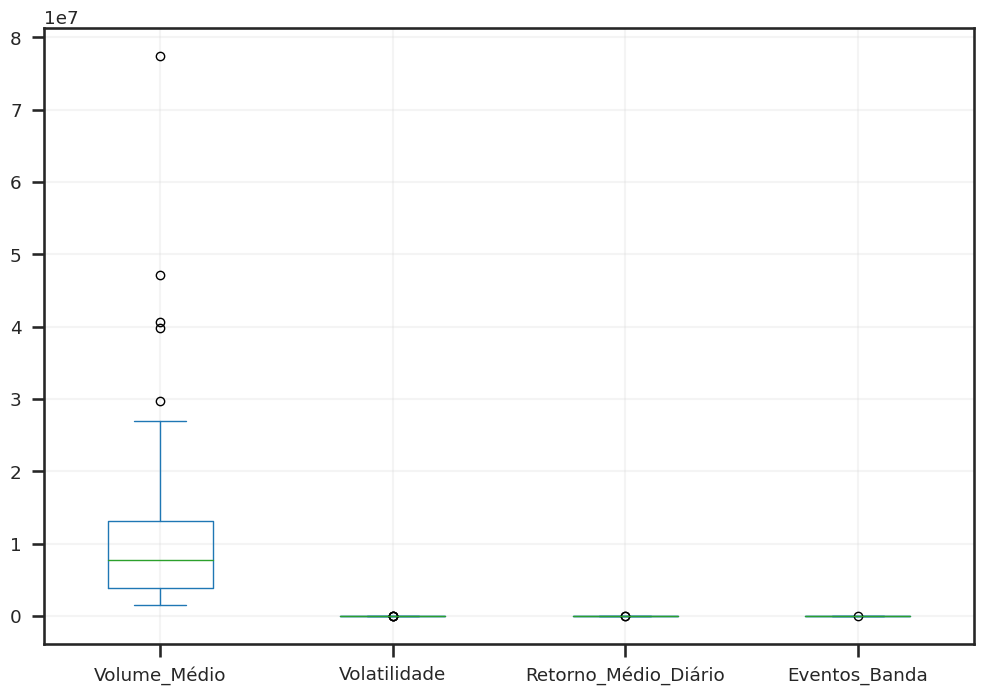

In [ ]:
features.plot.box()

#4) Modelagem

## 4.1) Normalização dos dados

In [ ]:
#Normalização
num_features = features.drop(columns = ['Ticker'])
scaler = PowerTransformer()
scaled_features = pd.DataFrame(scaler.fit_transform(num_features), index=num_features.index, columns=num_features.columns)
scaled_features

,Volume_Médio,Volatilidade,Retorno_Médio_Diário,Eventos_Banda
0,1.455898,-1.404436,-0.098112,0.428918
1,-0.412991,-1.008523,-1.278055,-1.574355
2,0.934089,0.074404,-1.809374,-2.150914
3,-0.650425,-1.717473,-0.417634,-1.858588
4,0.958164,0.705994,-1.418458,-1.298042
...,...,...,...,...
78,0.343047,0.696347,0.807502,0.720225
79,-1.157461,0.663083,0.125778,0.126323
80,-1.418067,1.193750,0.621416,1.204382
81,-0.044194,1.302981,0.695826,0.502782


<Axes: >

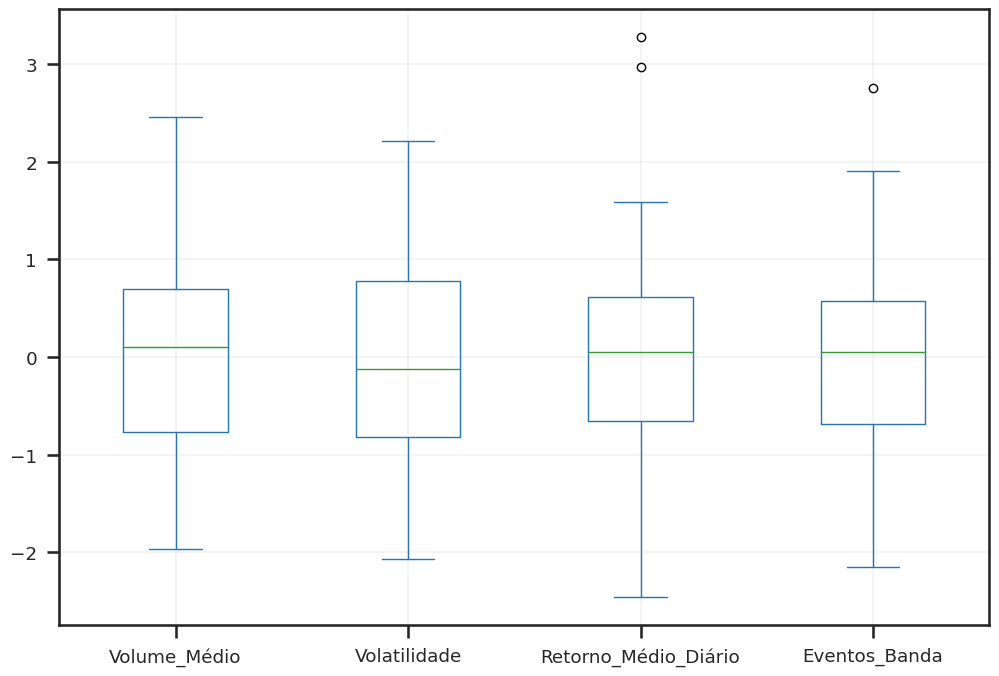

In [ ]:
scaled_features.plot.box()

##4.2) K-Means

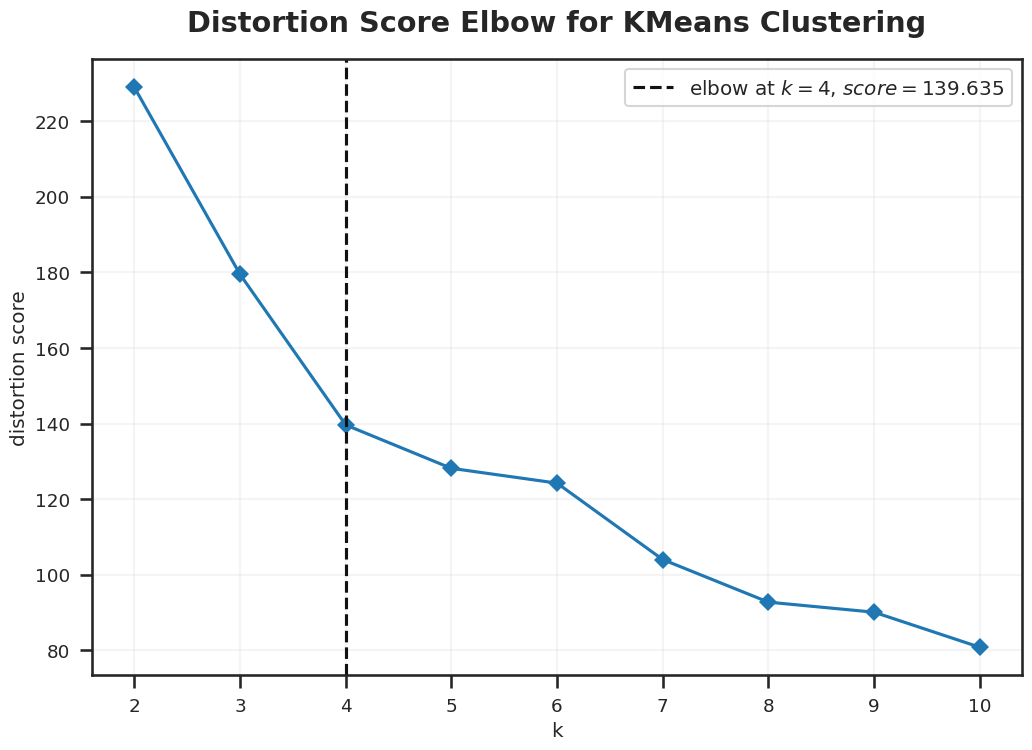

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [ ]:
kelbow_visualizer(KMeans(), scaled_features, k=10, timings=False)

In [ ]:
# Create list of dictionaries

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = scaled_features.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,230.895387,0.276521,1.246913,35.468330
3,189.753712,0.240980,1.359946,29.985456
4,139.152097,0.273973,1.119129,36.494801
5,122.951439,0.252790,1.185312,33.154935
6,116.662684,0.254248,1.086212,28.425496
7,104.699423,0.244104,1.103456,27.499107
8,100.437345,0.187005,1.177677,24.702251
9,93.139069,0.183161,1.267338,23.722200
10,88.237188,0.192141,1.223242,22.407641


In [ ]:
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(scaled_features)
features['Cluster_Kmeans'] = kmeans_labels

##4.3 Hierarchical Clustering

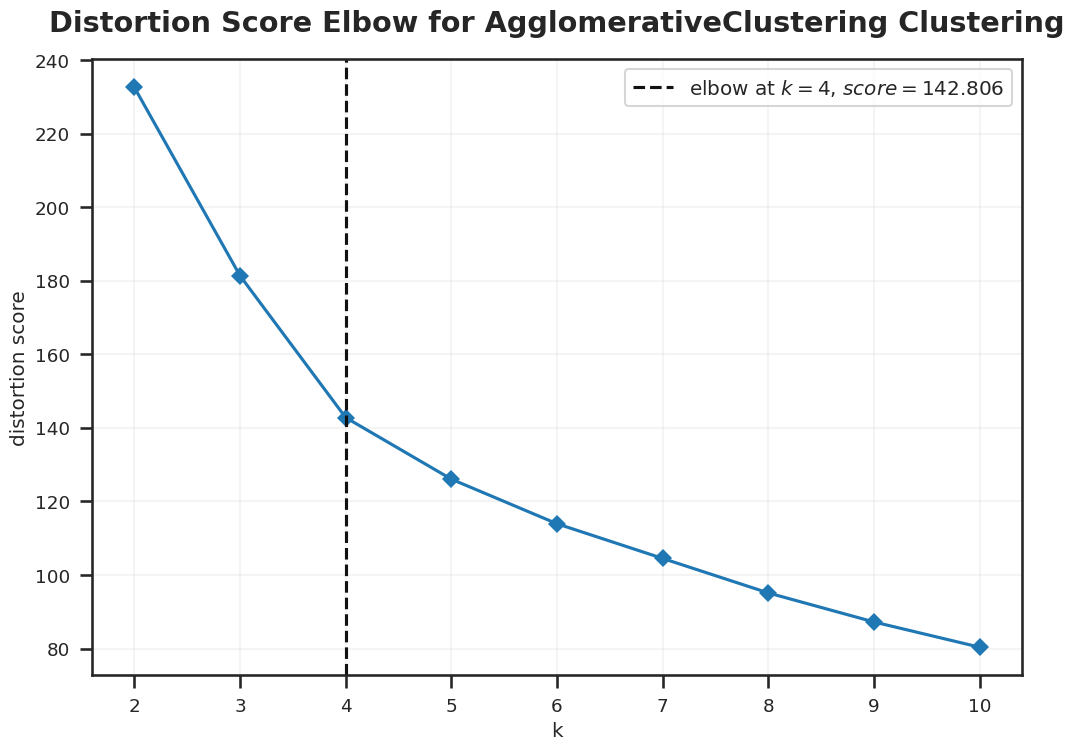

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [ ]:
kelbow_visualizer(AgglomerativeClustering(), scaled_features, k=10, timings=False)

In [ ]:
# Create list of dictionaries

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = scaled_features.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  # cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.269431,1.250869,34.616048
3,0.239246,1.244945,33.216709
4,0.249885,1.170853,34.887335
5,0.252489,1.198880,31.853859
6,0.237919,1.408149,29.472169
7,0.236793,1.354953,27.570249
8,0.249288,1.234207,26.676799
9,0.259295,1.156658,25.951373
10,0.259924,1.030770,25.389871


In [ ]:
hclust = AgglomerativeClustering(n_clusters=5)
hclust_labels = hclust.fit_predict(scaled_features)
features['Cluster_Hclust'] = hclust_labels

##4.4) Gaussian Mixture

In [ ]:
# Select best model by covariance type and K (Practical Statistics for Data Scientists)
results = []
k_range = range(1,9)
covariance_types = ['full', 'tied', 'diag', 'spherical']
X = scaled_features.copy()

for n_components in k_range:
  for covariance_type in covariance_types:
    mclust = GaussianMixture(n_components=n_components, n_init=10, warm_start=True, covariance_type=covariance_type)
    mclust.fit(X)
    results.append({
      'bic': mclust.bic(X),
      'n_components': n_components,
      'covariance_type': covariance_type,
    })

results = pd.DataFrame(results)
results.sort_values('bic').head()

,bic,n_components,covariance_type
0,922.531055,1,full
1,922.531055,1,tied
5,930.998041,2,tied
9,942.265728,3,tied
13,945.000500,4,tied


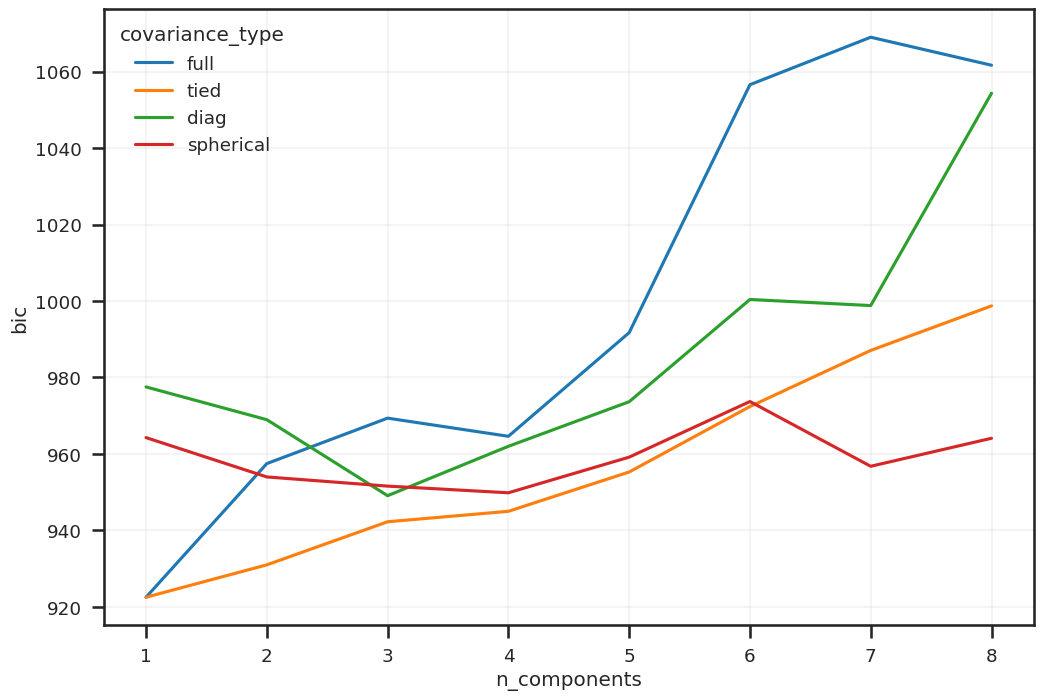

In [ ]:
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type');

In [ ]:
mclust = GaussianMixture(n_components=4, covariance_type='diag', n_init=10)
mclust_labels = mclust.fit_predict(scaled_features)
features['Cluster_Mclust'] = mclust_labels

In [ ]:
##4.5) Tabela comparativa
features[['Ticker', 'Cluster_Kmeans', 'Cluster_Hclust', 'Cluster_Mclust']]

,Ticker,Cluster_Kmeans,Cluster_Hclust,Cluster_Mclust
0,ABEV3.SA,1,2,1
1,ALPA4.SA,3,4,0
2,ASAI3.SA,1,4,0
3,AURE3.SA,3,4,0
4,AZUL4.SA,1,1,0
...,...,...,...,...
78,VBBR3.SA,0,0,2
79,VIVA3.SA,2,3,3
80,VIVT3.SA,0,0,2
81,WEGE3.SA,0,0,2


#5) Interpretação dos clusters (K-Means)


In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=scaled_features.columns)

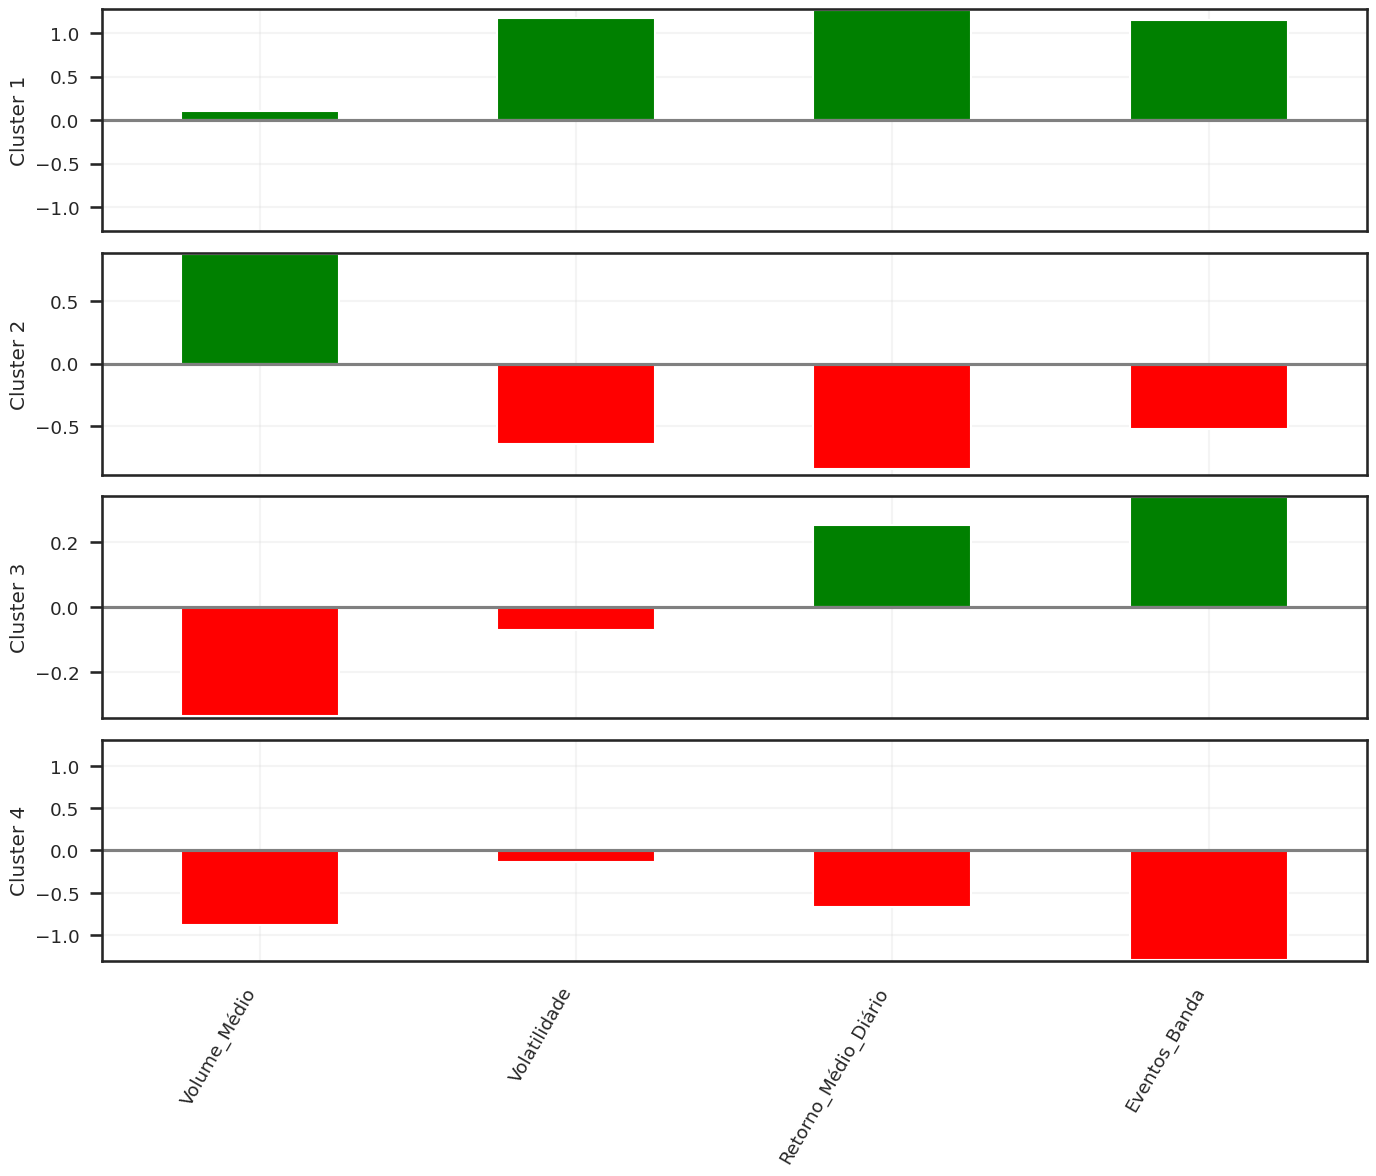

In [ ]:
# Adaptado do livro "Practical Statistics for Data Scientists"
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
(
  scaled_features.assign(cluster=kmeans_labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,0,1,2,3
Volume_Médio,0.109331,0.880903,-0.338452,-0.886005
Volatilidade,1.169615,-0.641102,-0.071093,-0.135739
Retorno_Médio_Diário,1.260436,-0.844136,0.254110,-0.663788
Eventos_Banda,1.147127,-0.522191,0.339601,-1.297789


#6) Gráfico interativo para visualização das cotações e bandas de bollinger

In [ ]:
abt_data_cluster = abt_data.merge(features[['Ticker', 'Cluster_Kmeans']], on='Ticker')

In [ ]:
# Definindo a função de atualização dos tickers
def atualizar_tickers(cluster):
    # Filtra os tickers com base no cluster selecionado
    return abt_data_cluster[abt_data_cluster['Cluster_Kmeans'] == cluster]['Ticker'].unique()

# Função principal para plotagem
def plotar_bandas_bollinger(ticker, cluster):
    df_ticker = abt_data_cluster[(abt_data_cluster['Ticker'] == ticker) & (abt_data_cluster['Cluster_Kmeans'] == cluster)]

    plt.figure(figsize=(14, 7))
    plt.plot(df_ticker['Date'], df_ticker['Adj Close'], label='Preço (Adj Close)', color='blue')
    plt.plot(df_ticker['Date'], df_ticker['Média_Móvel'], label='Média Móvel', color='orange')
    plt.plot(df_ticker['Date'], df_ticker['Banda_Superior'], label='Banda Superior', color='green', linestyle='--')
    plt.plot(df_ticker['Date'], df_ticker['Banda_Inferior'], label='Banda Inferior', color='red', linestyle='--')

    # Pintar o desvio padrão entre as bandas
    plt.fill_between(df_ticker['Date'], df_ticker['Banda_Superior'], df_ticker['Banda_Inferior'], color='grey', alpha=0.3)

    plt.title(f'Bandas de Bollinger - {ticker} (Cluster: {cluster})')
    plt.xlabel('Data')
    plt.ylabel('Preço Ajustado')
    plt.legend()
    plt.show()

# Função de interação
def interacao(cluster):
    # Atualiza os tickers com base no cluster selecionado
    tickers_filtrados = atualizar_tickers(cluster)

    # Cria o dropdown para tickers filtrados
    ticker = widgets.Dropdown(
        options=tickers_filtrados,
        description='Ticker:',
        disabled=False
    )

    # Chama a função de plotagem interativa
    interact(plotar_bandas_bollinger, ticker=ticker, cluster=widgets.fixed(cluster))

# Cria o dropdown para clusters
cluster_dropdown = widgets.Dropdown(
    options=features['Cluster_Kmeans'].unique(),
    description='Cluster:',
    disabled=False
)

# Inicia a interação
interact(interacao, cluster=cluster_dropdown)

interactive(children=(Dropdown(description='Cluster:', options=(1, 3, 0, 2), value=1), Output()), _dom_classes…

<function __main__.interacao(cluster)>